In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import sys
sys.path.append("..")
from utils import *
from merge_utils import *
import re
import gc

In [2]:
from sklearn.model_selection import TimeSeriesSplit, KFold

In [2]:
df_trans = pd.read_csv('./data/train_transaction.csv', index_col='TransactionID')
df_test_trans = pd.read_csv('./data/test_transaction.csv', index_col='TransactionID')

df_id = pd.read_csv('./data/train_identity.csv', index_col='TransactionID')
df_test_id = pd.read_csv('./data/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('./data/sample_submission.csv', index_col='TransactionID')

df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, right_index=True)
del df_trans, df_test_trans, df_id, df_test_id
print(df_train.shape)
print(df_test.shape)

(590540, 433)
(506691, 432)


In [3]:
df_train.rename({'isFraud': 'label'}, axis=1, inplace=True)
df_test.rename({'isFraud': 'label'}, axis=1, inplace=True)
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 648.22 Mb (66.8% reduction)
Mem. usage decreased to 563.43 Mb (66.3% reduction)


In [4]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_train["Date"] = df_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df_train['_Weekdays'] = df_train['Date'].dt.dayofweek
df_train['_Hours'] = df_train['Date'].dt.hour
df_train['_Days'] = df_train['Date'].dt.day

START_DATE_test = '2018-06-01'
startdate = datetime.datetime.strptime(START_DATE_test, "%Y-%m-%d")
df_test["Date"] = df_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df_test['_Weekdays'] = df_test['Date'].dt.dayofweek
df_test['_Hours'] = df_test['Date'].dt.hour
df_test['_Days'] = df_test['Date'].dt.day

In [5]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def definie_indexes(df):
    # create card ID 
    cards_cols= ['card1', 'card2', 'card3', 'card5', 'card4', 'card6']
    for card in cards_cols: 
        if '1' in card: 
            df['Card_ID']= df[card].map(str)
        else : 
            df['Card_ID']+= ' '+df[card].map(str)
    
    # sort train data by Card_ID and then by transaction date 
    df= df.sort_values(['Card_ID', 'Date'], ascending=[True, True])
    
    # small correction of the Card_ID
    df['Card_ID']=df['Card_ID'].apply(corret_card_id)
    
    # set indexes 
    # df= df.set_index(['Card_ID', 'Date'])
    return df

df_train = definie_indexes(df_train)
df_test = definie_indexes(df_test)

In [113]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [2]:
import pickle
df_train = pickle.load(open('./data/df_train_raw.pkl', 'rb'))
df_test = pickle.load(open('./data/df_test_raw.pkl', 'rb'))

In [3]:
from sklearn import preprocessing
cat_cols = ['id_%i'%x for x in range(12, 39)] + ['M%i'%x for x in range(1, 10)] + \
            [ 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'Card_ID']
for col in cat_cols:
    if col in df_train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))  

In [9]:
df_train_big = df_train[df_train['Date'].dt.month != 5]
df_test_oot = df_train[df_train['Date'].dt.month == 5]
df_train_train, df_train_val = split_data_v2(df_train_big, 0.2, 20190727)
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.5,                  
    'max_depth': 20,  
    'num_leaves': 12,
    'subsample': 0.7,  
    'colsample_bytree': 0.5,       
    'min_child_weight': 100,
    'reg_alpha': 0.,
    'reg_lambda': 0.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
f = df_train_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
# f = [x for x in f if '#' not in x] +['#test1','#test2','#test3',]
# f.remove('card1')
#f = [x for x in df_train.columns.drop(['label', 'TransactionDT', 'Date']) if '#' not in x]
print('特征个数: %i'%len(f))
model, score = xgb_model_v2(params, df_train_train, df_train_val, df_test_oot, f, 'label', num_boost_round=500)

特征个数: 434
[0]	train-auc:0.898505	val0-auc:0.867687	val1-auc:0.835786
Multiple eval metrics have been passed: 'val1-auc' will be used for early stopping.

Will train until val1-auc hasn't improved in 100 rounds.
[5]	train-auc:0.942454	val0-auc:0.912491	val1-auc:0.881228
[10]	train-auc:0.951826	val0-auc:0.921	val1-auc:0.890417
[15]	train-auc:0.956671	val0-auc:0.925312	val1-auc:0.89787
[20]	train-auc:0.96028	val0-auc:0.928076	val1-auc:0.900288
[25]	train-auc:0.963607	val0-auc:0.930567	val1-auc:0.902282
[30]	train-auc:0.966672	val0-auc:0.933206	val1-auc:0.904184
[35]	train-auc:0.969179	val0-auc:0.935508	val1-auc:0.906776
[40]	train-auc:0.971452	val0-auc:0.937413	val1-auc:0.908487
[45]	train-auc:0.973799	val0-auc:0.939403	val1-auc:0.910949
[50]	train-auc:0.975724	val0-auc:0.941411	val1-auc:0.912033
[55]	train-auc:0.977524	val0-auc:0.943243	val1-auc:0.913445
[60]	train-auc:0.979059	val0-auc:0.944638	val1-auc:0.915084
[65]	train-auc:0.980595	val0-auc:0.946249	val1-auc:0.916652
[70]	train-auc:

In [17]:
feature_important = model.get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())
data_baseline = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_baseline.head(15)

,score
card1,4780
TransactionAmt,4207
card2,3912
addr1,2939
_Days,2880
_Hours,2593
D15,2452
dist1,1971
D4,1947
P_emaildomain,1847


In [118]:
df_train['TransactionAmt#round'] = df_train['TransactionAmt'].round()
count(df_train, 'TransactionAmt#round')

(                      total       1      rate
 TransactionAmt#round                         
 (-0.001, 26.0]        61116  3415.0  0.055877
 (26.0, 36.0]          60996  1960.0  0.032133
 (36.0, 49.0]          64390  2056.0  0.031930
 (49.0, 58.0]          59969  1204.0  0.020077
 (58.0, 69.0]          50190  1383.0  0.027555
 (69.0, 100.0]         72004  2608.0  0.036220
 (100.0, 117.0]        72060  1421.0  0.019720
 (117.0, 160.0]        33487  1421.0  0.042434
 (160.0, 275.0]        57275  2191.0  0.038254
 (275.0, 31936.0]      59053  3004.0  0.050870, 0.11771436312443714)

In [15]:
df_train['#test'] = df_train.groupby('TransactionAmt')['TransactionAmt'].transform('count')
count(df_train, '#test')

(                    total       1      rate
 #test                                      
 (0.999, 42.0]       59363  4060.0  0.068393
 (42.0, 243.0]       59125  4773.0  0.080727
 (243.0, 971.0]      58791  2125.0  0.036145
 (971.0, 2516.0]     59737  1706.0  0.028559
 (2516.0, 5127.0]    62666  1892.0  0.030192
 (5127.0, 7682.0]    61515  1332.0  0.021653
 (7682.0, 11098.0]   57100  1361.0  0.023835
 (11098.0, 20390.0]  65117  1738.0  0.026690
 (20390.0, 28958.0]  76537  1030.0  0.013458
 (28958.0, 30589.0]  30589   646.0  0.021119, 0.3289233434906769)

In [4]:
def newFeature0(df_train):
    for num_col in ['TransactionAmt', 'id_02', 'D1', 'D2', 'D4', 'D15', 'C13', 'D8', 'D10', 'D11', 'C1', 'dist1']:
        for cat_col in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
                        'ProductCD', 'DeviceType', 'id_19', 'id_20', 'id_32', 'P_emaildomain']:
            df_train['%s_%s#test1'%(num_col, cat_col)] = df_train.groupby(cat_col)[num_col].transform('mean')
            df_train['%s_%s#test2'%(num_col, cat_col)] = df_train[num_col]-df_train.groupby(cat_col)[num_col].transform('mean')
            df_train['%s_%s#test3'%(num_col, cat_col)] = df_train[num_col]/df_train.groupby(cat_col)[num_col].transform('mean')
            df_train['%s_%s#test4'%(num_col, cat_col)] = df_train['%s_%s#test2'%(num_col, cat_col)]/ \
                                                         df_train.groupby(cat_col)[num_col].transform('std')
newFeature0(df_train)
newFeature0(df_test)

In [25]:
for x in f:
    if '#' in x:
        print(count(df_train, x))

(                              total       1      rate
TransactionAmt_addr1#test1                           
(4.3149999999999995, 43.094]  66716  7855.0  0.117738
(43.094, 126.625]             58270  1477.0  0.025348
(126.625, 132.375]            68580  1769.0  0.025795
(132.375, 135.0]              46708   949.0  0.020318
(135.0, 141.5]                56261  1313.0  0.023338
(141.5, 147.0]                65042  1374.0  0.021125
(147.0, 151.75]               56043  1427.0  0.025463
(151.75, 156.625]             60131  1548.0  0.025744
(156.625, 173.0]              61400  1725.0  0.028094
(173.0, 2464.0]               51389  1226.0  0.023857, 0.47017218676219485)
(                            total       1      rate
TransactionAmt_card2#test1                         
(33.593, 56.094]            59073  7343.0  0.124304
(56.094, 100.062]           68300   673.0  0.009854
(100.062, 123.062]          50073  1098.0  0.021928
(123.062, 128.625]          59605  1336.0  0.022414
(128.625, 132.5]

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                      total        1      rate
dist1_card3#test4                             
(-2.673, 0.0]      238147.0   4750.0  0.019946
(0.0, 2.479]           71.0      0.0  0.000000
NaN                352322.0  15913.0  0.045166, 0.15144926604584155)
(                     total        1      rate
D15_addr2#test1                              
(-0.001, 34.125]   66220.0   7793.0  0.117683
(34.125, 183.0]   524206.0  12845.0  0.024504
(183.0, 258.0]         5.0      1.0  0.200000
NaN                  109.0     24.0  0.220183, 0.4610447008753082)
(                     total       1      rate
D4_card2#test4                              
(-3.202, -0.825]   42261.0   933.0  0.022077
(-0.825, -0.76]    43305.0  1099.0  0.025378
(-0.76, -0.703]    42134.0   917.0  0.021764
(-0.703, -0.618]   40951.0  1637.0  0.039975
(-0.618, -0.455]   42166.0  2704.0  0.064127
(-0.455, -0.31]    42153.0  3512.0  0.083316
(-0.31, 0.2]       42164.0  1095.0  0.025970
(0.2, 0.964]       42192.0  1005.0  0.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                                 total       1      rate
C13_addr1#test4                                         
(-3.1279999999999997, -0.311]  59187.0  1762.0  0.029770
(-0.311, -0.292]               61170.0  2225.0  0.036374
(-0.292, -0.282]               67467.0  1289.0  0.019106
(-0.282, -0.271]               49803.0  1420.0  0.028512
(-0.271, -0.25]                58380.0  1506.0  0.025797
(-0.25, -0.209]                58547.0  1515.0  0.025877
(-0.209, -0.14]                60883.0  3285.0  0.053956
(-0.14, -0.123]                58254.0  4208.0  0.072235
(-0.123, 0.0706]               57609.0  2190.0  0.038015
(0.0706, 17.688]               59032.0  1263.0  0.021395
NaN                              208.0     0.0  0.000000, 0.18649460646185956)
(                                    total       1      rate
TransactionAmt_P_emaildomain#test2                         
(-255.501, -110.25]                 60028  2044.0  0.034051
(-110.25, -94.688]                  58156  2246.0  0.03

(                         total        1      rate
D11_addr2#test2                                  
(-199.626, -146.625]  112175.0   2188.0  0.019505
(-146.625, -139.625]   12771.0    921.0  0.072117
(-139.625, -103.625]   30999.0    851.0  0.027452
(-103.625, -37.625]    31049.0    632.0  0.020355
(-37.625, 65.375]      31063.0    490.0  0.015774
(65.375, 189.375]      31023.0    422.0  0.013603
(189.375, 315.5]       31075.0    322.0  0.010362
(315.5, 523.5]         31098.0    280.0  0.009004
NaN                   279287.0  14557.0  0.052122, 0.346340684471492)
(                   total       1      rate
C13_card4#test4                           
(-0.306, -0.25]   151843  6687.0  0.044039
(-0.25, -0.242]    47020  3042.0  0.064696
(-0.242, -0.238]   62924  1856.0  0.029496
(-0.238, -0.23]    41056  1600.0  0.038971
(-0.23, -0.211]    59283  2066.0  0.034850
(-0.211, -0.178]   52782  1444.0  0.027358
(-0.178, -0.125]   57542  1416.0  0.024608
(-0.125, 0.0382]   59895  1373.0  0.02292

(                                 total       1      rate
D15_addr1#test4                                         
(-1.5659999999999998, -0.899]  50392.0  1185.0  0.023516
(-0.899, -0.849]               49842.0  1390.0  0.027888
(-0.849, -0.81]                50285.0  1379.0  0.027424
(-0.81, -0.592]                49994.0  1512.0  0.030244
(-0.592, -0.337]               81914.0  6076.0  0.074175
(-0.337, -0.21]                18264.0   971.0  0.053165
(-0.21, 0.343]                 50119.0  1166.0  0.023265
(0.343, 1.021]                 50107.0   912.0  0.018201
(1.021, 1.607]                 50161.0   929.0  0.018520
(1.607, 7.277]                 50063.0   862.0  0.017218
NaN                            89399.0  4281.0  0.047886, 0.2766378907542055)
(                     total       1      rate
C13_id_19#test3                             
(-0.001, 0.0276]  156624.0  7912.0  0.050516
(0.0276, 0.0346]   23458.0  1607.0  0.068505
(0.0346, 0.0829]   83196.0  2857.0  0.034341
(0.0829, 0.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                      total       1      rate
D1_addr1#test1                               
(-0.001, 35.281]    67611.0  7950.0  0.117584
(35.281, 87.688]    80283.0  2026.0  0.025236
(87.688, 90.625]    40418.0  1018.0  0.025187
(90.625, 95.812]    87011.0  2376.0  0.027307
(95.812, 98.875]    25509.0   708.0  0.027755
(98.875, 100.875]   87873.0  1994.0  0.022692
(100.875, 104.438]  30437.0   924.0  0.030358
(104.438, 115.125]  62161.0  1239.0  0.019932
(115.125, 117.938]  68755.0  1675.0  0.024362
(117.938, 524.5]    40478.0   753.0  0.018603
NaN                     4.0     0.0  0.000000, 0.48283937258942405)
(                         total        1      rate
dist1_card3#test2                                
(-834.001, -117.312]   38120.0    891.0  0.023374
(-117.312, -116.312]   16988.0    200.0  0.011773
(-116.312, -114.312]   25824.0    364.0  0.014095
(-114.312, -112.312]   21795.0    407.0  0.018674
(-112.312, -110.312]   17032.0    253.0  0.014854
(-110.312, -106.312]   25352

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                     total        1      rate
D1_addr2#test3                               
(-0.001, 0.0293]  296054.0  13490.0  0.045566
(0.0293, 0.303]    58869.0   2755.0  0.046799
(0.303, 0.831]     57820.0   1400.0  0.024213
(0.831, 1.818]     58670.0   1154.0  0.019669
(1.818, 3.695]     59008.0    870.0  0.014744
(3.695, 64.688]    58682.0    932.0  0.015882
NaN                 1437.0     62.0  0.043145, 0.1909668358936611)
(                            total       1      rate
TransactionAmt_id_20#test3                         
(0.00181, 0.205]            59112  1201.0  0.020317
(0.205, 0.299]              59017  1352.0  0.022909
(0.299, 0.384]              79236  1576.0  0.019890
(0.384, 0.397]              39086   801.0  0.020493
(0.397, 0.586]              58975  2149.0  0.036439
(0.586, 0.719]              61123  1825.0  0.029858
(0.719, 0.864]              56911  1932.0  0.033948
(0.864, 1.312]              58973  2764.0  0.046869
(1.312, 2.066]              60804  3227.0  

(                     total       1      rate
C13_card6#test2                             
(-36.626, -35.625]  147462  4632.0  0.031411
(-35.625, -34.625]   42658  1171.0  0.027451
(-34.625, -31.625]   60649  1485.0  0.024485
(-31.625, -26.625]   50572  1020.0  0.020169
(-26.625, -20.484]   54013  3508.0  0.064947
(-20.484, -19.484]   74943  3134.0  0.041818
(-19.484, -15.484]   44016  2418.0  0.054935
(-15.484, 4.375]     57952  2059.0  0.035529
(4.375, 2896.0]      58275  1236.0  0.021210, 0.13906822552272846)
(                    total        1      rate
D1_card2#test3                              
(-0.001, 0.031]  294658.0  13218.0  0.044859
(0.031, 0.306]    59126.0   2931.0  0.049572
(0.306, 0.831]    58729.0   1348.0  0.022953
(0.831, 1.792]    58970.0   1208.0  0.020485
(1.792, 3.529]    58894.0    960.0  0.016300
(3.529, 121.5]    58894.0    952.0  0.016165
NaN                1269.0     46.0  0.036249, 0.179686126260005)
(                      total       1      rate
C1_card1#

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                    total        1      rate
D10_id_20#test3                             
(-0.001, 0.115]  256304.0  12165.0  0.047463
(0.115, 0.423]    50981.0   1134.0  0.022244
(0.423, 0.99]     50845.0    839.0  0.016501
(0.99, 1.973]     51044.0    765.0  0.014987
(1.973, 3.33]     51284.0    793.0  0.015463
(3.33, 1679.0]    50969.0    631.0  0.012380
NaN               79113.0   4336.0  0.054808, 0.28727531184831157)
(                       total       1      rate
D4_ProductCD#test1                            
 6.289062            33024.0  1574.0  0.047662
 53.375000           68519.0  8008.0  0.116873
 156.000000         439670.0  8969.0  0.020399
 193.375000          37699.0  1426.0  0.037826
NaN                  11628.0   686.0  0.058996, 0.5575641649447554)
(                        total        1      rate
D8_DeviceType#test4                             
(-0.695, -0.691]       8211.0   1149.0  0.139934
(-0.691, -0.672]       6802.0   1342.0  0.197295
(-0.672, -0.587]       7

(                                 total       1      rate
C1_ProductCD#test2                                      
(-48.812999999999995, -44.812]   60794  3834.0  0.063065
(-44.812, -8.047]               249633  8719.0  0.034927
(-8.047, -7.047]                 85265  1666.0  0.019539
(-7.047, -6.047]                 44887   805.0  0.017934
(-6.047, -4.047]                 40654   945.0  0.023245
(-4.047, -0.224]                 57126  1387.0  0.024280
(-0.224, 4636.0]                 52181  3307.0  0.063376, 0.1868112788142494)
(                       total        1      rate
D1_ProductCD#test3                             
(-0.001, 0.0297]    295013.0  13403.0  0.045432
(0.0297, 0.275]      59631.0   2738.0  0.045916
(0.275, 0.756]       58191.0   1386.0  0.023818
(0.756, 1.658]       58899.0   1188.0  0.020170
(1.658, 3.395]       58641.0    893.0  0.015228
(3.395, 172.375]     58896.0   1009.0  0.017132
NaN                   1269.0     46.0  0.036249, 0.17713634023112834)
(         

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                     total       1      rate
C13_card4#test2                             
(-33.095, -32.094]  161120  8267.0  0.051310
(-32.094, -31.938]   62924  1856.0  0.029496
(-31.938, -31.094]   36775  1432.0  0.038939
(-31.094, -30.094]   40454  1492.0  0.036881
(-30.094, -27.938]   53382  1758.0  0.032932
(-27.938, -22.094]   64226  1744.0  0.027154
(-22.094, -14.094]   55826  1577.0  0.028248
(-14.094, 4.906]     57353  1367.0  0.023835
(4.906, 2886.0]      58480  1170.0  0.020007, 0.10585447833162479)
(                 total        1      rate
D1_id_32#test1                           
0.000000             6      3.0  0.500000
19.406250        24428   1630.0  0.066727
31.390625        53071   1800.0  0.033917
66.250000           81     18.0  0.222222
104.437500      512954  17212.0  0.033555, 0.030126602284612728)
(                        total        1      rate
D8_addr1#test2                                  
(-278.251, -189.75]    7543.0    826.0  0.109506
(-189.75, -159.7

(                      total        1      rate
D8_card5#test1                                
(-0.001, 106.25]   125981.0   6714.0  0.053294
(106.25, 113.125]   57266.0    630.0  0.011001
(113.125, 171.25]  332375.0  10933.0  0.032894
(171.25, 175.75]    25977.0    356.0  0.013704
(175.75, 876.0]     41703.0   1968.0  0.047191
NaN                  7238.0     62.0  0.008566, 0.18282447454723103)
(                     total        1      rate
D1_card4#test3                               
(-0.001, 0.0306]  296136.0  13641.0  0.046063
(0.0306, 0.306]    57579.0   2837.0  0.049271
(0.306, 0.857]     59305.0   1368.0  0.023067
(0.857, 1.878]     58679.0   1241.0  0.021149
(1.878, 3.816]     58729.0    836.0  0.014235
(3.816, 16.688]    58843.0    694.0  0.011794
NaN                 1269.0     46.0  0.036249, 0.2304884693111663)
(                      total       1      rate
id_02_card3#test4                            
(-1.916, -0.911]    14090.0  2389.0  0.169553
(-0.911, -0.721]    14119.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(                               total       1      rate
C13_card2#test4                                       
(-2.2159999999999997, -0.319]  67563  1793.0  0.026538
(-0.319, -0.301]               52617  1384.0  0.026303
(-0.301, -0.28]                61129  1443.0  0.023606
(-0.28, -0.247]                54914  1375.0  0.025039
(-0.247, -0.222]               59247  1651.0  0.027866
(-0.222, -0.186]               60560  1891.0  0.031225
(-0.186, -0.14]                59097  2038.0  0.034486
(-0.14, -0.101]                57401  4111.0  0.071619
(-0.101, 0.0746]               59010  3761.0  0.063735
(0.0746, 32.812]               59002  1216.0  0.020609, 0.20119885326387077)
(                     total        1      rate
D15_id_19#test1                              
(-0.001, 39.906]   59233.0   7812.0  0.131886
(39.906, 180.5]   505405.0  12026.0  0.023795
(180.5, 801.0]     25056.0    761.0  0.030372
NaN                  846.0     64.0  0.075650, 0.5273211822347535)
(                  

KeyboardInterrupt: 

In [10]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
with open('./data/df_train_agg.pkl', 'wb') as f:
    pickle.dump(df_train, f)
with open('./data/df_test_agg.pkl', 'wb') as f:
    pickle.dump(df_test, f)

Mem. usage decreased to 1318.97 Mb (15.0% reduction)
Mem. usage decreased to 1138.95 Mb (14.9% reduction)


In [3]:
import pickle
df_train = pickle.load(open('./data/df_train_agg.pkl', 'rb'))
df_test = pickle.load(open('./data/df_test_agg.pkl', 'rb'))

In [3]:
test_todrop = [x for x in df_train.columns if 'test2' in x or 'test3' in x]
df_train.drop(test_todrop, axis=1, inplace=True)
df_test.drop(test_todrop, axis=1, inplace=True)
gc.collect()

21

In [66]:
df_train['TransactionAmt#log'] = np.log(df_train['TransactionAmt'])

In [88]:
count(df_train, '#test', 10)

(                    total       1      rate
 #test                                      
 (0.614, 48.594]     59848  5963.0  0.099636
 (48.594, 90.312]    58488  2424.0  0.041444
 (90.312, 101.188]   60574   710.0  0.011721
 (101.188, 111.062]  57953  1068.0  0.018429
 (111.062, 120.188]  61062  1446.0  0.023681
 (120.188, 129.125]  56637  1179.0  0.020817
 (129.125, 142.25]   59171  1246.0  0.021058
 (142.25, 181.625]   59219  1346.0  0.022729
 (181.625, 233.75]   59467  2427.0  0.040813
 (233.75, 3454.0]    58121  2854.0  0.049104, 0.4209971185352771)

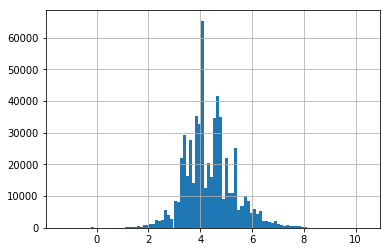

In [50]:
np.log(df_train['TransactionAmt']).hist(bins=100)

In [5]:
def xgb_model_v3(params, df_train, df_val, df_test, features, label='label', num_boost_round=200):
    Dtrain = xgb.DMatrix(df_train[features], df_train[label])
    Dval = xgb.DMatrix(df_val[features], df_val[label])
    watchlist = [(Dtrain, 'train'), (Dval, 'val')]
    model = xgb.train(params, dtrain=Dtrain, early_stopping_rounds=100, 
                      evals=watchlist, num_boost_round=num_boost_round, verbose_eval=20)
    auc = model.best_score
    print('model best auc: %.4f at ntree_limit-%i'%(auc, model.best_ntree_limit))
    del Dtrain, Dval
    gc.collect()
#     Dtest = xgb.DMatrix(df_test[features])
#     pred = model.predict(Dtest, model.best_ntree_limit)
    return model, auc

In [35]:
gc.collect()
from sklearn.model_selection import TimeSeriesSplit, KFold
folds = KFold(n_splits=5, shuffle=True)
f = [x for x in df_train_big.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID']) if '#' not in x]
auc_lst = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    _, auc = xgb_model_v3(params, df_train.iloc[train_index, :], df_train.iloc[valid_index, :], df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    gc.collect()
print(np.mean(auc_lst))

[0]	train-auc:0.926214	val-auc:0.835256
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.995274	val-auc:0.940981
[40]	train-auc:0.997768	val-auc:0.946881
[60]	train-auc:0.998926	val-auc:0.952501
[80]	train-auc:0.999384	val-auc:0.956699
[100]	train-auc:0.999636	val-auc:0.959822
[120]	train-auc:0.999765	val-auc:0.961718
[140]	train-auc:0.999842	val-auc:0.963486
[160]	train-auc:0.999901	val-auc:0.965025
[180]	train-auc:0.999934	val-auc:0.965807
[200]	train-auc:0.999958	val-auc:0.966513
[220]	train-auc:0.999972	val-auc:0.967023
[240]	train-auc:0.999979	val-auc:0.96745
[260]	train-auc:0.999986	val-auc:0.968043
[280]	train-auc:0.999991	val-auc:0.968412
[300]	train-auc:0.999993	val-auc:0.968737
[320]	train-auc:0.999995	val-auc:0.969101
[340]	train-auc:0.999997	val-auc:0.969359
[360]	train-auc:0.999997	val-auc:0.969512
[380]	train-auc:0.999998	val-auc:0.969646
[400]	train-auc:0.999998	va

In [36]:
gc.collect()
df_train = df_train.sort_values('TransactionDT')
gc.collect()
folds = TimeSeriesSplit(n_splits=5)
f = [x for x in df_train_big.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID']) if '#' not in x]
auc_lst = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    _, auc = xgb_model_v3(params, df_train.iloc[train_index, :], df_train.iloc[valid_index, :], df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    gc.collect()
print(auc_lst)
print(np.mean(auc_lst))

[0]	train-auc:0.925631	val-auc:0.677289
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.998885	val-auc:0.866494
[40]	train-auc:0.999665	val-auc:0.878266
[60]	train-auc:0.999863	val-auc:0.886419
[80]	train-auc:0.999938	val-auc:0.893151
[100]	train-auc:0.99997	val-auc:0.896177
[120]	train-auc:0.999986	val-auc:0.896972
[140]	train-auc:0.999994	val-auc:0.897756
[160]	train-auc:0.999997	val-auc:0.898392
[180]	train-auc:0.999999	val-auc:0.898257
[200]	train-auc:1	val-auc:0.89884
[220]	train-auc:1	val-auc:0.898712
[240]	train-auc:1	val-auc:0.898703
[260]	train-auc:1	val-auc:0.898635
[280]	train-auc:1	val-auc:0.898568
[300]	train-auc:1	val-auc:0.899185
[320]	train-auc:1	val-auc:0.899347
[340]	train-auc:1	val-auc:0.899156
[360]	train-auc:1	val-auc:0.899511
[380]	train-auc:1	val-auc:0.899338
[400]	train-auc:1	val-auc:0.899214
[420]	train-auc:1	val-auc:0.899235
[440]	train-auc:1	val-auc:0.

In [6]:
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.5,                  
    'max_depth': 20,  
    'num_leaves': 12,
    'subsample': 0.7,  
    'colsample_bytree': 0.5,       
    'min_child_weight': 100,
    'reg_alpha': 10.,
    'reg_lambda': 10.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
folds = TimeSeriesSplit(n_splits=5)
f = df_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
#f = [x for x in f if 'test2' not in x  and 'test4' not in x]
# to_drop = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
#                     'ProductCD', 'DeviceType', 'id_19', 'id_20', 'id_32', 'P_emaildomain']
# f = list(set(f)-set(to_drop))
auc_lst = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(df_train)):
    _, auc = xgb_model_v3(params, df_train.iloc[train_index, :], df_train.iloc[valid_index, :], df_test, f, 'label', num_boost_round=600)
    auc_lst.append(auc)
    gc.collect()
print(auc_lst)
print(np.mean(auc_lst))

[0]	train-auc:0.914831	val-auc:0.774992
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.974027	val-auc:0.845039
[40]	train-auc:0.983439	val-auc:0.843791
[60]	train-auc:0.989512	val-auc:0.850392
[80]	train-auc:0.992842	val-auc:0.849503
[100]	train-auc:0.994833	val-auc:0.846673
[120]	train-auc:0.996037	val-auc:0.8468
[140]	train-auc:0.996949	val-auc:0.84587
[160]	train-auc:0.997552	val-auc:0.845898
Stopping. Best iteration:
[61]	train-auc:0.98976	val-auc:0.851086

model best auc: 0.8511 at ntree_limit-62
[0]	train-auc:0.920056	val-auc:0.8141
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.975888	val-auc:0.861552
[40]	train-auc:0.984702	val-auc:0.859499
[60]	train-auc:0.990173	val-auc:0.858532
[80]	train-auc:0.992999	val-auc:0.861032
[100]	train-auc:0.994938	val-auc:0.859408

In [20]:
try:
    del model
except:
    pass
# df_train_big = df_train[df_train['Date'].dt.month != 5]
# df_test_oot = df_train[df_train['Date'].dt.month == 5]
print(df_train_big.shape)
print(df_test_oot.shape)
#df_train_train, df_train_val = split_data_v2(df_train_big, 0.2, 20190727)
gc.collect()
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.05,   
    'gamma': 0.5,                  
    'max_depth': 20,  
    'num_leaves': -1,
    'subsample': 0.7,  
    'colsample_bytree': 0.6,       
    'min_child_weight': 10,
    'reg_alpha': 0.,
    'reg_lambda': 0.,
    'scale_pos_weight': 27.6,               
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
f = df_train_big.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID'])
f = [x for x in f if 'test1' not in x and 'test2' not in x and 'test3' not in x]
to_drop = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
                    'ProductCD', 'DeviceType', 'id_19', 'id_20', 'id_32', 'P_emaildomain']
#f = list(set(f)-set(to_drop))
#f = [x for x in df_train_train.columns.drop(['label', 'TransactionDT', 'Date', 'Card_ID']) if '#' not in x]
# f = f +['#test1','#test2','#test3', '#test']
print('特征个数: %i'%len(f))
model = xgb_model_v3(params, df_train_big, df_test_oot, df_test, f, 'label', num_boost_round=400)

(500867, 1110)
(89673, 1110)
特征个数: 602
[0]	train-auc:0.935221	val-auc:0.758264
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[20]	train-auc:0.997159	val-auc:0.89876
[40]	train-auc:0.998872	val-auc:0.910149
[60]	train-auc:0.999439	val-auc:0.917839
[80]	train-auc:0.999681	val-auc:0.921271
[100]	train-auc:0.999809	val-auc:0.922805
[120]	train-auc:0.999876	val-auc:0.924416
[140]	train-auc:0.999919	val-auc:0.924807
[160]	train-auc:0.999949	val-auc:0.925588
[180]	train-auc:0.999967	val-auc:0.925873
[200]	train-auc:0.999981	val-auc:0.926556
[220]	train-auc:0.999988	val-auc:0.927072
[240]	train-auc:0.999992	val-auc:0.927675
[260]	train-auc:0.999995	val-auc:0.927791
[280]	train-auc:0.999996	val-auc:0.927976
[300]	train-auc:0.999997	val-auc:0.928195
[320]	train-auc:0.999998	val-auc:0.927956
[340]	train-auc:0.999999	val-auc:0.927893
[360]	train-auc:0.999999	val-auc:0.928004
[380]	train-auc:0.999999	val-a

In [28]:
def newFeature(df_train):
    df_train['count_last'] = df_train.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).count())
    df_train['mean_last'] = df_train.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
    df_train['min_last'] = df_train.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).min())
    df_train['max_last'] = df_train.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).max())
    df_train['std_last'] = df_train.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())
    df_train['trans_mean_last'] = df_train['TransactionAmt'] / df_train['mean_last']
    df_train['trans_std_last'] = df_train['TransactionAmt'] / df_train['std_last']
    df_train['TransactionAmt_to_mean_card_id'] = df_train['TransactionAmt'] - df_train.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
    df_train['TransactionAmt_to_std_card_id'] = df_train['TransactionAmt_to_mean_card_id'] / df_train.groupby(['Card_ID'])['TransactionAmt'].transform('std')
    df_train['id_02_to_mean_card_id'] = df_train['id_02'] / df_train.groupby(['Card_ID'])['id_02'].transform('mean')
    df_train['id_02_to_std_card_id'] = df_train['id_02'] / df_train.groupby(['Card_ID'])['id_02'].transform('std')
    df_train['D15_to_mean_card_id'] = df_train['D15'] / df_train.groupby(['Card_ID'])['D15'].transform('mean')
    df_train['D15_to_std_card_id'] = df_train['D15'] / df_train.groupby(['Card_ID'])['D15'].transform('std')
    df_train['D15_to_mean_addr1'] = df_train['D15'] / df_train.groupby(['addr1'])['D15'].transform('mean')
    df_train['D15_to_std_addr1'] = df_train['D15'] / df_train.groupby(['addr1'])['D15'].transform('std')
newFeature(df_train)
newFeature(df_test)


In [22]:
one_value_cols = [col for col in df_train.columns if df_train[col].nunique() <= 1]
one_value_cols_test = [col for col in df_test.columns if df_test[col].nunique() <= 1]
print(one_value_cols)
print(one_value_cols_test)

[]
['V107']


In [23]:
many_null_cols = [col for col in df_train.columns if df_train[col].isnull().mean() > 0.9]
many_null_cols_test = [col for col in df_test.columns if df_test[col].isnull().mean() > 0.9]
print(many_null_cols)
print(many_null_cols_test)

['dist2', 'D7', 'id_07', 'id_08']
['dist2', 'id_07', 'id_08']


In [24]:
big_top_value_cols = [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in df_test.columns if df_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
print(big_top_value_cols)
print(big_top_value_cols_test)

['label', 'dist2', 'C3', 'D7', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
['dist2', 'C3', 'V14', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V55', 'V65', 'V66', 'V67', 'V68', 'V77', 'V86', 'V88', 'V89', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V297', 'V298', '

In [25]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test +
                        big_top_value_cols +
                        big_top_value_cols_test +
                        one_value_cols+ one_value_cols_test))
cols_to_drop.remove('label')
len(cols_to_drop)

82

In [43]:
threshold = 0.98
    
# Absolute value correlation matrix
corr_matrix = df_train[df_train['label'].notnull()].corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
df_train = df_train.drop(columns = to_drop)
df_test = df_test.drop(columns = to_drop)

There are 60 columns to remove.


In [70]:
df_train_big = df_train[df_train['Date'].dt.month != 5]
df_test_oot = df_train[df_train['Date'].dt.month == 5]
df_train_train, df_train_val = split_data_v2(df_train_big, 0.2, 20190727)

In [73]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'gamma': 0.5,                  
    'max_depth': 21,  
    'num_leaves': 12,
    'lambda': 0.2,                   
    'subsample': 0.7,  
    'feature_fraction': 3,
    'colsample_bytree': 0.8,       
    'min_child_weight': 100,
    'min_child_samples': 21,
    'reg_alpha': 0.6,
    'reg_lambda': 0.3,
    'scale_pos_weight': 10,
    'eta': 0.05,   
    'n_jobs': -1,                  
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
f = df_train.columns.drop(['isFraud', 'TransactionDT', 'Date'])
print('特征个数: %i'%len(f))
model, score = xgb_model_v2(params, df_train_train, df_train_val, df_test_oot, f, 'isFraud', num_boost_round=300)

特征个数: 308
[0]	train-auc:0.900898	val0-auc:0.878782	val1-auc:0.833502
Multiple eval metrics have been passed: 'val1-auc' will be used for early stopping.

Will train until val1-auc hasn't improved in 100 rounds.
[5]	train-auc:0.93598	val0-auc:0.909796	val1-auc:0.88445
[10]	train-auc:0.941518	val0-auc:0.913979	val1-auc:0.888341
[15]	train-auc:0.94509	val0-auc:0.917917	val1-auc:0.891427
[20]	train-auc:0.947715	val0-auc:0.919547	val1-auc:0.893423
[25]	train-auc:0.950839	val0-auc:0.921875	val1-auc:0.895557
[30]	train-auc:0.953442	val0-auc:0.924451	val1-auc:0.897841
[35]	train-auc:0.955827	val0-auc:0.926201	val1-auc:0.899984
[40]	train-auc:0.958458	val0-auc:0.928948	val1-auc:0.902068
[45]	train-auc:0.960914	val0-auc:0.930834	val1-auc:0.903823
[50]	train-auc:0.963005	val0-auc:0.932622	val1-auc:0.905022
[55]	train-auc:0.964923	val0-auc:0.934273	val1-auc:0.907226
[60]	train-auc:0.966655	val0-auc:0.935985	val1-auc:0.908881
[65]	train-auc:0.968414	val0-auc:0.937323	val1-auc:0.910344
[70]	train-au

In [75]:
feature_important = model.get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(10)

,score
card1,3088
card2,2328
addr1,1874
TransactionAmt,1685
trans_std_last,1664
TransactionAmt_to_mean_card_id,1634
_Days,1631
TransactionAmt_to_std_card_id,1546
mean_last,1517
max_last,1381


In [132]:
class FeatureEncode:
    def __init__(self, label):
        self.label = label
        self.code_map_dict = dict()
        self.mean_code_map_dict = dict()

    def replace_encode(self, data, f, cands):
        data['%s#encode' % f] = (data[f].isin(cands) * data[f]).replace(
            {cands[i]: (i + 1) for i in range(len(cands))})
    
    def mean_encode(self, data, f, tol):
        if f not in self.mean_code_map_dict:
            count_table = data[[self.label, f]].groupby(f).agg(['count', 'sum'])[self.label]
            count_table['rate'] = count_table['sum'] / count_table['count']
            code_map ={}
            for k, v in count_table.iterrows():
                if v['count'] > tol:
                    code_map[k] = v['rate']
                else:
                    code_map[k] = 999
            self.mean_code_map_dict[f] = code_map
        return data[f].map(self.mean_code_map_dict[f])
    
    def merge_encode(self, data, f, tol, max_intervals, include_nan=False):
        if f not in self.code_map_dict:
            merge_value_lst = [x for x in highFreq(data, f, self.label, tol, plot=False)
                               if x != 999999]
            merge_value = {}
            for i in range(len(merge_value_lst)):
                if str(merge_value_lst[i]) == 'nan':
                    merge_value['nan'] = i
                else:
                    merge_value[merge_value_lst[i]] = i
            merge_idx = data[f].isin(merge_value) | data[f].isnull()
            data_tmp = data[[self.label, f]].copy()
            if include_nan:
                data_tmp[f].fillna('nan', inplace=True)
            data_tmp.loc[merge_idx, f] = data_tmp.loc[merge_idx, f].map(merge_value)
            intervals_info = chiMerge(data_tmp[merge_idx], f, self.label, max_intervals)
            count_table = data[[self.label, f]].groupby(f).agg(['count', 'sum'])[self.label]
            count_table['rate'] = count_table['sum'] / count_table['count']
            code_map = {}
            if include_nan and 'nan' in merge_value:
                idx = merge_value['nan']
                for x in intervals_info:
                    if idx >= intervals_info[x]['bound'][0] and idx <= intervals_info[x]['bound'][1]:
                        code_map['nan'] = x
                        break
            for k, v in count_table.iterrows():
                if str(k) == 'nan':
                    k = 'nan'
                code = np.nan
                if k in merge_value:
                    idx = merge_value[k]
                    for x in intervals_info:
                        if idx >= intervals_info[x]['bound'][0] and idx <= intervals_info[x]['bound'][1]:
                            code = x
                            break
                else:
                    gap = {x: abs(v['rate'] - intervals_info[x]['num'][1] / intervals_info[x]['num'][0])
                           for x in intervals_info}
                    code = sorted(gap, key=lambda x: gap[x])[0] if gap else np.nan
                code_map[k] = code
            self.code_map_dict[f] = code_map
        if include_nan:
            res = data[f].fillna('nan').map(self.code_map_dict[f])
        else:
            res = data[f].map(self.code_map_dict[f])
        return res

    def main_trans(self, data, method='merge'):
        n = data.shape[0]
        for col in ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + \
                   ['card%i' % i for i in range(1, 7)] + \
                   ['M%i' % i for i in range(1, 10)]:
            try:
                if method == 'merge':
                    data['%s#encode' % col] = self.merge_encode(data, col, 10000, 5)
                elif method == 'mean':
                    data['%s#encode' % col] = self.mean_encode(data, col, 10000)
            except:
                pass
                
    def main_id(self, data, method='merge'):
        for col in ['DeviceType', 'DeviceInfo'] + ['id_%i' % i for i in range(12, 39)]:
            try:
                if method == 'merge':
                    data['%s#encode' % col] = self.merge_encode(data, col, 5000, 5, True)
                elif method == 'mean':
                    data['%s#encode' % col] = self.mean_encode(data, col, 5000)
            except:
                pass

In [133]:
E = FeatureEncode('label')
E.main_trans(df_train_big, 'mean')
E.main_trans(df_test_oot, 'mean')
E.main_id(df_train_big, 'mean')
E.main_id(df_test_oot, 'mean')

c:\users\高铭\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\高铭\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [128]:
f0 = df_train.columns.drop(['label', 'TransactionDT', 'Date'])
f = []
for x in f0:
    if '%s#encode'%x in f0:
        f.append('%s#encode'%x)
    else:
        f.append(x)
f = sorted(list(set(f)))
f

['C1',
 'C13',
 'C4',
 'C5',
 'C7',
 'C9',
 'D1',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15',
 'D15_to_mean_addr1',
 'D15_to_mean_card_id',
 'D15_to_std_addr1',
 'D15_to_std_card_id',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'DeviceInfo#encode',
 'DeviceType#encode',
 'M1#encode',
 'M2#encode',
 'M3#encode',
 'M4#encode',
 'M5#encode',
 'M6#encode',
 'M7#encode',
 'M8#encode',
 'M9#encode',
 'P_emaildomain#encode',
 'ProductCD#encode',
 'R_emaildomain#encode',
 'TransactionAmt',
 'TransactionAmt_to_mean_card_id',
 'TransactionAmt_to_std_card_id',
 'V1',
 'V10',
 'V100',
 'V11',
 'V12',
 'V13',
 'V130',
 'V131',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V151',
 'V152',
 'V153',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V165',
 'V166',
 'V168',
 'V169',
 'V17',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V180',
 'V181',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187'

In [134]:
count(df_train_big, 'card1#encode', 100)

(               total        1      rate
 card1#encode                           
 0.007694       12477     96.0  0.007694
 0.035684       11854    423.0  0.035684
 999.000000    476536  17050.0  0.035779, 0.031551491504161894)

In [137]:
# df_train_big = df_train[df_train['Date'].dt.month != 5]
# df_test_oot = df_train[df_train['Date'].dt.month == 5]
df_train_train, df_train_val = split_data_v2(df_train_big, 0.2, 20190727)
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'gamma': 0.5,                  
    'max_depth': 21,  
    'num_leaves': 12,
    'lambda': 0.2,                   
    'subsample': 0.7,  
    'feature_fraction': 3,
    'colsample_bytree': 0.8,       
    'min_child_weight': 100,
    'min_child_samples': 21,
    'reg_alpha': 10.,
    'reg_lambda': 10.,
    'scale_pos_weight': 10,
    'eta': 0.05,   
    'n_jobs': -1,                  
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist',
}
f = df_train.columns.drop(['label', 'TransactionDT', 'Date'])
#f = [x for x in df_train.columns.drop(['label', 'TransactionDT', 'Date']) if '#' not in x]
print('特征个数: %i'%len(f))
model, score = xgb_model_v2(params, df_train_train, df_train_val, df_test_oot, f, 'label', num_boost_round=300)

特征个数: 347
[0]	train-auc:0.888045	val0-auc:0.874817	val1-auc:0.84848
Multiple eval metrics have been passed: 'val1-auc' will be used for early stopping.

Will train until val1-auc hasn't improved in 100 rounds.
[5]	train-auc:0.924203	val0-auc:0.909723	val1-auc:0.884638
[10]	train-auc:0.930599	val0-auc:0.91329	val1-auc:0.887972
[15]	train-auc:0.935054	val0-auc:0.916113	val1-auc:0.888877
[20]	train-auc:0.93981	val0-auc:0.918902	val1-auc:0.891331
[25]	train-auc:0.94385	val0-auc:0.921383	val1-auc:0.893682
[30]	train-auc:0.946988	val0-auc:0.923297	val1-auc:0.89578
[35]	train-auc:0.950136	val0-auc:0.925745	val1-auc:0.897788
[40]	train-auc:0.952912	val0-auc:0.927679	val1-auc:0.899846
[45]	train-auc:0.955406	val0-auc:0.929598	val1-auc:0.900882
[50]	train-auc:0.957853	val0-auc:0.93143	val1-auc:0.902908
[55]	train-auc:0.960144	val0-auc:0.933388	val1-auc:0.90496
[60]	train-auc:0.962087	val0-auc:0.93501	val1-auc:0.906769
[65]	train-auc:0.963914	val0-auc:0.936222	val1-auc:0.907992
[70]	train-auc:0.9